In [79]:
import dask.array as ds
import dask
import os
from satpy import Scene, MultiScene, find_files_and_readers
from satpy.composites import GenericCompositor, DifferenceCompositor
from satpy.writers import to_image
from trollimage.colormap import spectral
from pyresample.geometry import AreaDefinition
import xarray as xarray
import yaml
import cartopy
from glob import glob

In [3]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

<Axes: >

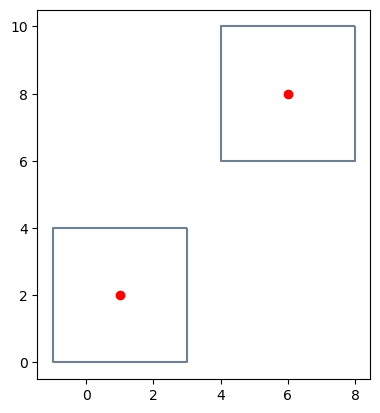

In [3]:
# Generate some sample data 
p1 = Point((1,2))
p2 = Point((6,8))
points = gpd.GeoSeries([p1,p2])

# Buffer the points using a square cap style
# Note cap_style: round = 1, flat = 2, square = 3
buffer = points.buffer(2, cap_style = 3)

# Plot the results
fig, ax1 = plt.subplots()
buffer.boundary.plot(ax=ax1, color = 'slategrey')
points.plot(ax = ax1, color = 'red')

In [4]:
kvarnakershamn = Point((18.165, 57.2145))
gs = gpd.GeoSeries(kvarnakershamn)
gs.crs = "epsg:4326"

buffer = gs.to_crs(epsg=3006).buffer(10000, cap_style=3)
kvakh_bbox = buffer.translate(xoff=-9000)

In [5]:
gs.to_crs(epsg=3006)

0    POINT (691119.299 6345703.075)
dtype: geometry

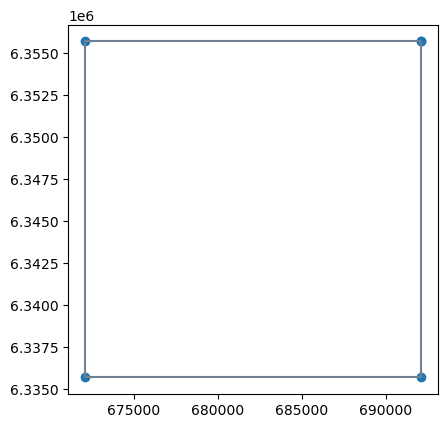

In [6]:
fig, ax1 = plt.subplots()
kvakh_bbox.boundary.plot(ax=ax1, color = 'slategrey')

vertices = kvakh_bbox[0].exterior.coords
plt.scatter(x=[coord[0] for coord in vertices], y=[coord[1] for coord in vertices])

In [7]:
print(kvakh_bbox[0])

POLYGON ((692119.2987237406 6355703.074740629, 692119.2987237406 6335703.074740629, 672119.2987237406 6335703.074740629, 672119.2987237406 6355703.074740629, 692119.2987237406 6355703.074740629))


In [8]:
POLYGON ((692119.2987237406 6355703.074740629, 692119.2987237406 6335703.074740629, 672119.2987237406 6335703.074740629, 672119.2987237406 6355703.074740629, 692119.2987237406 6355703.074740629))

SyntaxError: invalid syntax. Perhaps you forgot a comma? (154232778.py, line 1)

In [9]:
from satpy.utils import check_satpy
check_satpy()

Readers
abi_l1b:  ok
abi_l1b_scmi:  ok
abi_l2_nc:  ok
acspo:  ok
agri_fy4a_l1:  ok
agri_fy4b_l1:  ok
ahi_hrit:  ok
ahi_hsd:  ok
ahi_l1b_gridded_bin:  ok
ahi_l2_nc:  ok
ami_l1b:  ok
amsr2_l1b:  ok
amsr2_l2:  ok
amsr2_l2_gaasp:  ok
amsub_l1c_aapp:  ok
ascat_l2_soilmoisture_bufr:  cannot find module 'satpy.readers.ascat_l2_soilmoisture_bufr' (('Missing eccodes-python and/or eccodes C-library installation. Use conda to install eccodes.\n           Error: ', ModuleNotFoundError("No module named 'eccodes'")))
atms_l1b_nc:  ok
atms_sdr_hdf5:  ok
avhrr_l1b_aapp:  ok
avhrr_l1b_eps:  ok
avhrr_l1b_gaclac:  cannot find module 'satpy.readers.avhrr_l1b_gaclac' (No module named 'pygac')
avhrr_l1b_hrpt:  ok
avhrr_l1c_eum_gac_fdr_nc:  ok
caliop_l2_cloud:  cannot find module 'satpy.readers.caliop_l2_cloud' (No module named 'pyhdf')
clavrx:  cannot find module 'satpy.readers.clavrx' (No module named 'pyhdf')
cmsaf-claas2_l2_nc:  ok
electrol_hrit:  ok
epic_l1b_h5:  ok
fci_l1c_nc:  ok
fci_l2_nc:  ok
generi

In [10]:
from satpy.utils import debug_on
debug_on()

In [3]:
os.environ['SATPY_DASK_CHUNK_SIZE'] = '1024'
dask.config.set(num_workers=4)

In [12]:
# TODO Modularize
with open('../../config/satvis.yaml', 'r') as f:
    config = yaml.safe_load(f)

dir_dict = config['data_directories']
data_dir = dir_dict['sentinel2']

print(data_dir)

FileNotFoundError: [Errno 2] No such file or directory: '../../config/satvis.yaml'

In [ ]:
692119.2987237406 6355703.074740629, 692119.2987237406 6335703.074740629, 672119.2987237406 6335703.074740629, 672119.2987237406 6355703.074740629
minx = 672119.2987237406
maxx = 692119.2987237406
miny = 6335703.074740629
maxy = 6355703.074740629

In [4]:
kvarnakershamn_test = AreaDefinition.from_area_of_interest(area_id="kvarnakershamn", projection='epsg:3006', shape=[2000, 2000], center=[686119.299, 6345703.075], resolution=[10, 10])

In [7]:
algotltest_full = AreaDefinition.from_area_of_interest(area_id="algotltest_full", projection='epsg:3006', shape=[13000, 13000], center=[705573.556, 6371774.759], resolution=[10, 10])

In [5]:
kvarnakershamn_test

/home/janky/miniforge3/envs/ALGOTLvisTest/lib/python3.11/site-packages/pyproj/crs/crs.py:1293: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


Area ID: kvarnakershamn
Description: kvarnakershamn
Projection: {'ellps': 'GRS80', 'no_defs': 'None', 'proj': 'utm', 'type': 'crs', 'units': 'm', 'zone': '33'}
Number of columns: 2000
Number of rows: 2000
Area extent: (676119.299, 6335703.075, 696119.299, 6355703.075)

In [80]:
# algotltest_full stere 

algotltest = AreaDefinition(
    area_id="algotltest",
    description="ALGOTL area around Gotland",
    proj_id="stere",
    projection={"proj": "stere", "lat_0": 57.435, "lon_0": 18.674999999999997},
    width=3320,
    height=3170,
    # width=664,
    # height=634,
    area_extent=(-95043.345303, -98594.030733, 95043.345303, 100717.352397),
)

# algotlTest:
#   description: algotlTest
#   projection:
#     proj: stere
#     ellps: WGS84
#     lat_0: 57.435
#     lon_0: 18.674999999999997
#   shape:
#     height: 66
#     width: 63
#   area_extent:
#     lower_left_xy: [-95043.345303, -98594.030733]
#     upper_right_xy: [95043.345303, 100717.352397]

In [112]:
base_path = glob('/home/janky/Data/ALGOTL/')
file_lists = []

for path in base_path:
    for root, dirs, files in os.walk(path):
        file_lists.append([os.path.join(root, f) for f in files])

In [12]:
base_path = '/home/janky/Data/ALGOTL/'

In [6]:
dlist = [os.path.join(base_path, dir) for dir in os.listdir(base_path)]

In [7]:
dlist

['/home/janky/Data/ALGOTL/8',
 '/home/janky/Data/ALGOTL/7',
 '/home/janky/Data/ALGOTL/6',
 '/home/janky/Data/ALGOTL/5',
 '/home/janky/Data/ALGOTL/4',
 '/home/janky/Data/ALGOTL/3',
 '/home/janky/Data/ALGOTL/2',
 '/home/janky/Data/ALGOTL/1',
 '/home/janky/Data/ALGOTL/9']

In [13]:
base_path

'/home/janky/Data/ALGOTL/'

In [15]:
scn_list = []

files = find_files_and_readers(base_dir=base_path, reader='msi_safe')
scn = Scene(filenames=files, reader='msi_safe')
scn_list.append(scn)
scn_list

In [11]:
scn_list = []
for path in dlist:
    files = find_files_and_readers(base_dir=path, reader='msi_safe')
    scn = Scene(filenames=files, reader='msi_safe')
    scn_list.append(scn)
scn_list

ValueError: No supported files found

In [16]:
mscn = MultiScene(scn_list)

In [17]:
mscn.load(['true_color', 'B03', 'B04'])

In [18]:
algotl_mscn = mscn.resample(kvarnakershamn_test)

In [19]:
algotl_scn = algotl_mscn.blend()

In [31]:
compositor = DifferenceCompositor('diffcomp')
composite = compositor([algotl_scn['B04'], algotl_scn['B03']])

In [96]:
algotl_scn['B04'].values.mean()

4.921563

In [37]:
algotl_scn['kahru'] = algotl_scn['B04'] / algotl_scn['B03']

In [40]:
algotl_scn['kahru2'] = algotl_scn['B03'] / algotl_scn['B04']

In [ ]:
algotl_scn['kahru']

In [35]:
compositor = GenericCompositor('overview')
composite = compositor([algotl_scn['B04'], algotl_scn['B03']])

In [93]:
algotl_scn['kahru2'].values.mean()

1.5931878

In [85]:
img_tc = to_image(algotl_scn['true_color'])
img_tc.show()

In [112]:
img = to_image(algotl_scn['kahru2'])
img.stretch('crude', min_stretch=[1.0], max_stretch=[1.45])
spectral.set_range(1.0, 1.45)
# spectral.set_range(1, 2)
img.colorize(spectral)
img.show()

In [18]:
algotl_scn.save_datasets(writer='simple_image', filename='algotl_diff_test_output.png', base_dir='/home/janky/Data/')

/home/janky/miniforge3/envs/ALGOTLvisTest/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in log
  return func(*(_execute_task(a, cache) for a in args))


: 

: 

: 

/home/janky/miniforge3/envs/ALGOTLvisTest/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in log
  return func(*(_execute_task(a, cache) for a in args))


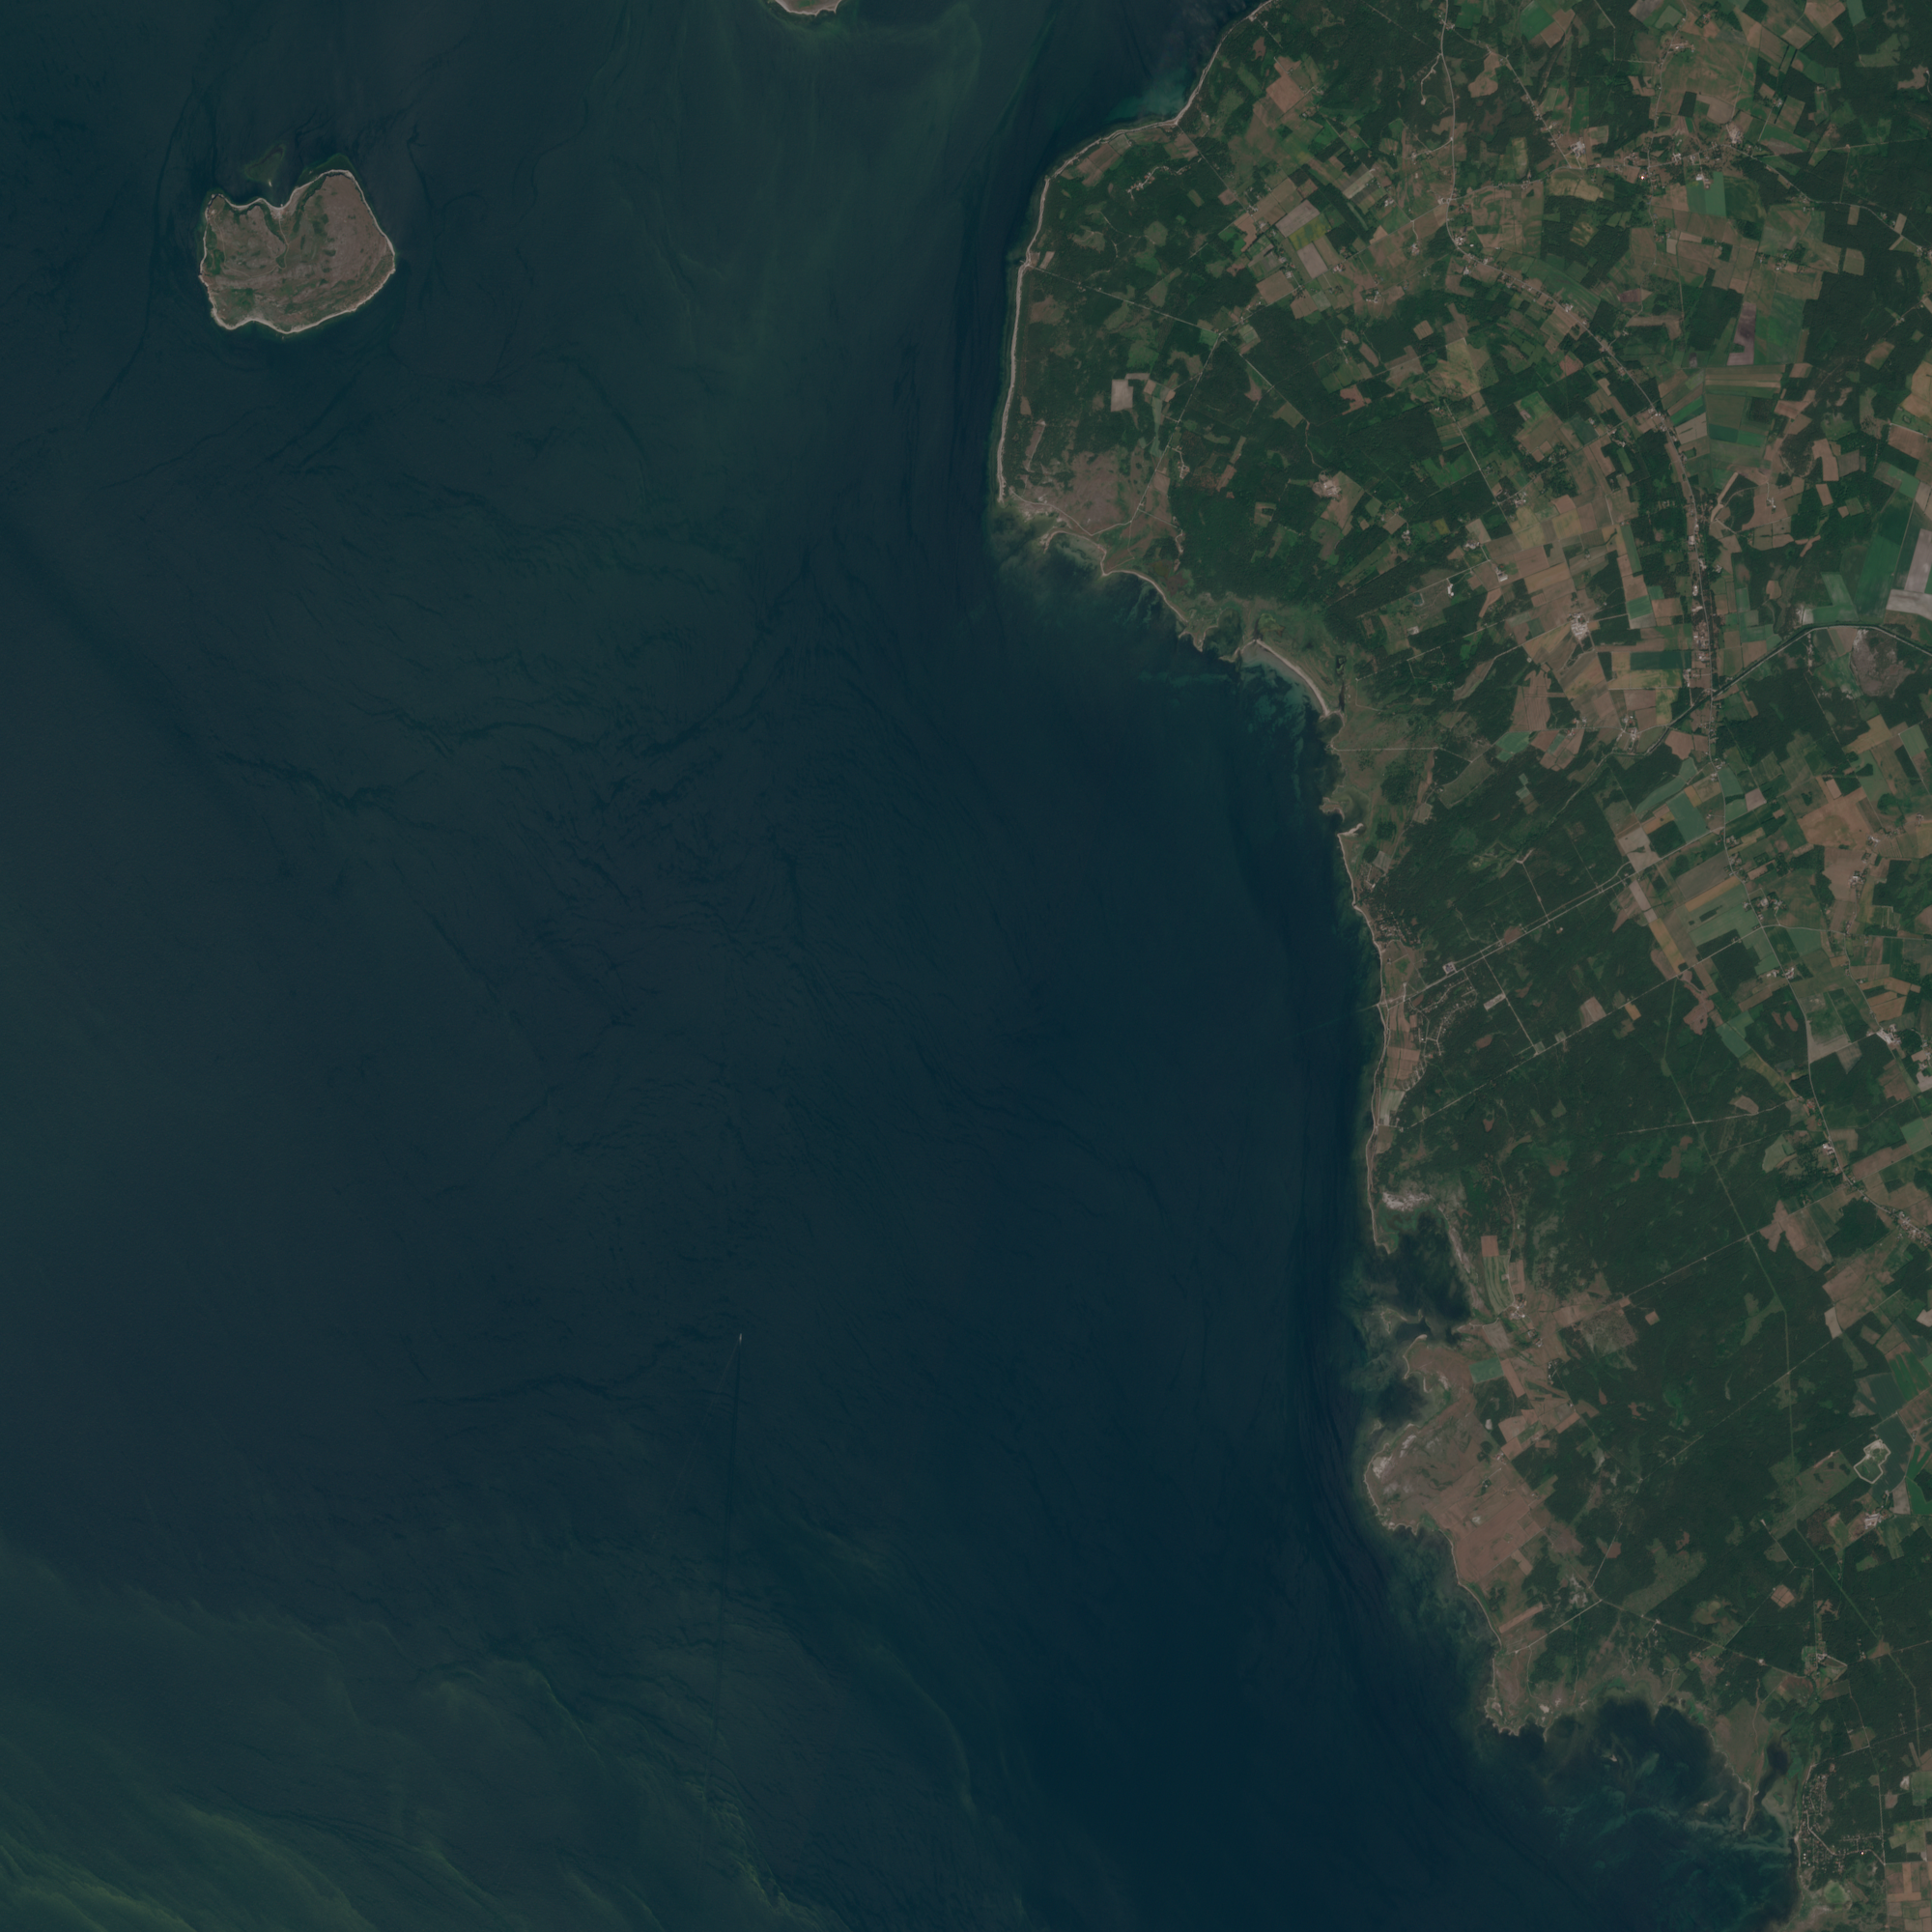

In [84]:
algotl_scn.show('true_color')

In [115]:
base_path

'/home/janky/Data/ALGOTL/'

In [117]:
bigger_files = find_files_and_readers(base_dir=base_path, reader='msi_safe')

In [119]:
scn = Scene(bigger_files)
scn.load(['true_color'])
scn.show('true_color')